In [133]:
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim
import en_core_web_sm
from tqdm import tqdm

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, NMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import silhouette_score

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [3]:
newsgroups_data = fetch_20newsgroups()

In [4]:
data = pd.DataFrame()
data['content'] = newsgroups_data.data[:1000] # take only first 1000 texts
data['label'] = newsgroups_data.target[:1000]

In [5]:
newsgroups_data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [6]:
data.head(3)

,content,label
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4


In [7]:
# Convert to list
texts = data.content.values.tolist()

# Remove Emails
texts = [re.sub('\S*@\S*\s?', '', sent) for sent in texts]

# Remove new line characters
texts = [re.sub('\s+', ' ', sent) for sent in texts]

# Remove distracting single quotes
texts = [re.sub("\'", "", sent) for sent in texts]

pprint(texts[:1])

<input>:5: DeprecationWarning: invalid escape sequence \S
<input>:5: DeprecationWarning: invalid escape sequence \S
<input>:5: DeprecationWarning: invalid escape sequence \S
<input>:5: DeprecationWarning: invalid escape sequence \S
<input>:5: DeprecationWarning: invalid escape sequence \S
<input>:5: DeprecationWarning: invalid escape sequence \S
<input>:5: DeprecationWarning: invalid escape sequence \S
<input>:5: DeprecationWarning: invalid escape sequence \S
<input>:5: DeprecationWarning: invalid escape sequence \S
<input>:5: DeprecationWarning: invalid escape sequence \S
<input>:8: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \S
<input>:8: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \S
<input>:8: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \S
<input>:8: DeprecationWarning: invalid escape sequence \s
<input>:5: Dep

['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I saw '
 'the other day. It was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ']


In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(texts))

print(data_words[:1])

[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


In [9]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en


# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

['where s thing subject car be nntp post host rac wam umd edu organization university maryland college park line be wonder anyone out there could enlighten car see other day be door sport car look be late early be call bricklin door be really small addition front bumper be separate rest body be know anyone can tellme model name engine spec year production where car be make history info have funky look car mail thank bring neighborhood lerxst', 'guy kuo subject si clock poll final call summary final call si clock report keyword si acceleration clock upgrade article shelley qvfo innc organization university washington line nntp post host carson washington fair number brave soul upgrade si clock oscillator have share experience poll send brief message detail experience procedure top speed attain cpu rate speed add card adapter heat sink hour usage day floppy disk functionality floppy be especially request will be summarize next day so add network knowledge base have do clock upgrade have 

In [131]:
def print_top_words(model, feature_names, n_top_words, print_topics=True):
    all_top_words = []
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        if print_topics:
            print(message)
        all_top_words.append([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
    return all_top_words

In [88]:
def coherence_score(tf,vocabulary,all_top_words):
    totalcnt = len(all_top_words)
    tf = tf > 0
    total = 0
    count = 0
    for i, allwords in enumerate(all_top_words):
        for word1 in allwords:
            for word2 in allwords:
                if word1 != word2:
                    ind1 = vocabulary[word1]
                    ind2 = vocabulary[word2]
                    #print (ind1,ind2)
                    total += np.log((np.matmul(np.array(tf[:,ind1]).ravel(),np.array(tf[:,ind2]).ravel()) + 1)/np.sum(tf[:,ind2]))
                    count += 1
    return total/count

In [113]:
vectorizer = CountVectorizer(max_df=0.7, min_df=2,
                                   max_features=50000,
                                   stop_words='english')
countvector = vectorizer.fit_transform(data_lemmatized)
countvector = countvector.todense()
vocabulary = dict(zip(vectorizer.get_feature_names(),np.arange(countvector.shape[1])))

In [114]:
print (countvector.shape)

(1000, 7600)


In [115]:
n_topics = 10

In [116]:
nmf = NMF(n_components=n_topics, random_state=123,
          alpha=.1, l1_ratio=.5).fit(countvector)

In [117]:
topic_words = print_top_words(nmf, tfidf_vectorizer.get_feature_names(), n_top_words=5)

Topic #0: ax max tm ey qq
Topic #1: matthew say prophecy gd make
Topic #2: health tobacco use smokeless report
Topic #3: argument fallacy conclusion example premise
Topic #4: armenian turkish russian people genocide
Topic #5: astronaut space nasa mission candidate
Topic #6: good excellent miss module fair
Topic #7: write say think article know
Topic #8: father son spirit holy proceed
Topic #9: come say armenian father people


In [118]:
print (coherence_score(countvector,vocabulary,topic_words))

-2.5517123526884298


In [128]:
top_topics = nmf.transform(countvector).argmax(axis=1)
print (silhouette_score(countvector,top_topics))

-0.0431841196875144


In [120]:
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=50,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

lda.fit(countvector)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=50.0,
                          max_doc_update_iter=100, max_iter=50,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [121]:
topic_words = print_top_words(lda, tfidf_vectorizer.get_feature_names(), n_top_words=5)

Topic #0: font tiff scope digital mhz
Topic #1: game play mb power israel
Topic #2: islamic islam rushdie law muslim
Topic #3: player league season playoff pitcher
Topic #4: ax max tm ey qq
Topic #5: armenian people turkish father genocide
Topic #6: car den year radius launch
Topic #7: ini window callback utility redirect
Topic #8: write use article say know
Topic #9: sex gay homosexual marriage cramer


In [122]:
print (coherence_score(countvector,vocabulary,topic_words))

-2.3998778106932708


In [123]:
lda.perplexity(countvector)

2306.1381018268353

In [129]:
top_topics = lda.transform(countvector).argmax(axis=1)
print (silhouette_score(countvector,top_topics))

-0.2557104515556845


In [141]:
nmf_coh_scores, nmf_sil_scores, lda_coh_scores, lda_sil_scores, lda_perplexity_scores = [], [], [], [], []

for numtopic in tqdm([10,20,50,75,100]):
    nmf = NMF(n_components=numtopic, random_state=123,
          alpha=.1, l1_ratio=.5).fit(countvector)
    topic_words = print_top_words(nmf, tfidf_vectorizer.get_feature_names(), n_top_words=5, print_topics=False)
    coh_nmf = coherence_score(countvector,vocabulary,topic_words)
    top_topics = nmf.transform(countvector).argmax(axis=1)
    sil_nmf = silhouette_score(countvector,top_topics)
    lda = LatentDirichletAllocation(n_components=numtopic, max_iter=50,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

    lda.fit(countvector)
    topic_words = print_top_words(lda, tfidf_vectorizer.get_feature_names(), n_top_words=5, print_topics=False)
    coh_lda = coherence_score(countvector,vocabulary,topic_words)
    top_topics = lda.transform(countvector).argmax(axis=1)
    sil_lda = silhouette_score(countvector,top_topics)
    
    nmf_coh_scores.append(coh_nmf)
    nmf_sil_scores.append(sil_nmf)
    lda_coh_scores.append(coh_lda)
    lda_sil_scores.append(sil_lda)
    lda_perplexity_scores.append(lda.perplexity(countvector))

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [07:13<00:00, 98.39s/it]


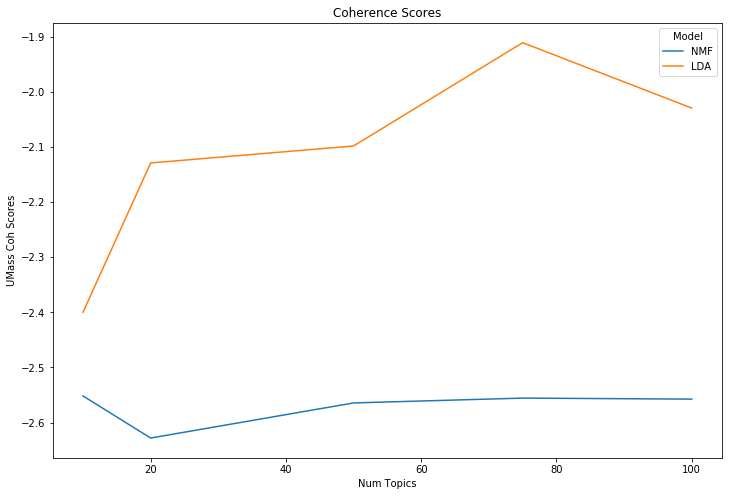

In [142]:
plt.figure(figsize=(12, 8))
plt.plot([10,20,50,75,100], nmf_coh_scores, label='NMF')
plt.plot([10,20,50,75,100], lda_coh_scores, label='LDA')
plt.title("Coherence Scores")
plt.xlabel("Num Topics")
plt.ylabel("UMass Coh Scores")
plt.legend(title='Model', loc='best')
plt.show()

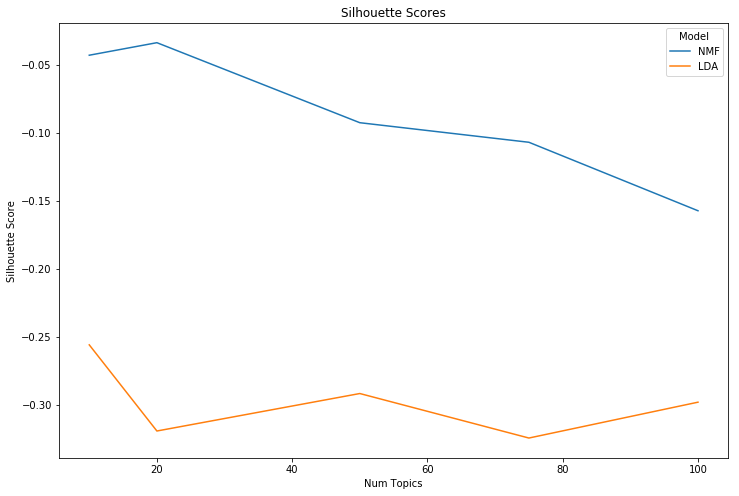

In [143]:
plt.figure(figsize=(12, 8))
plt.plot([10,20,50,75,100], nmf_sil_scores, label='NMF')
plt.plot([10,20,50,75,100], lda_sil_scores, label='LDA')
plt.title("Silhouette Scores")
plt.xlabel("Num Topics")
plt.ylabel("Silhouette Score")
plt.legend(title='Model', loc='best')
plt.show()

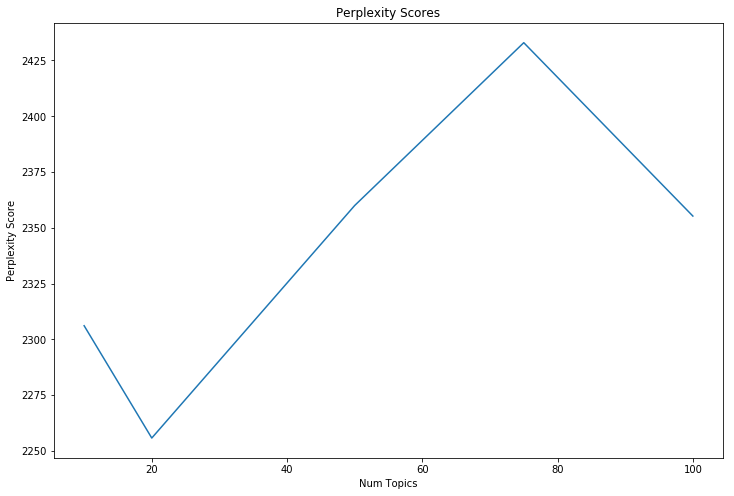

In [145]:
plt.figure(figsize=(12, 8))
plt.plot([10,20,50,75,100], lda_perplexity_scores)
plt.title("Perplexity Scores")
plt.xlabel("Num Topics")
plt.ylabel("Perplexity Score")
plt.show()

In [138]:
nmf_sil_scores

[-0.0431841196875144,
 -0.0431841196875144,
 -0.0431841196875144,
 -0.0431841196875144,
 -0.0431841196875144]

In [139]:
lda_sil_scores

[-0.2557104515556845,
 -0.2557104515556845,
 -0.2557104515556845,
 -0.2557104515556845,
 -0.2557104515556845]

In [140]:
lda_perplexity_scores

[2306.1381018268353,
 2306.1381018268353,
 2306.1381018268353,
 2306.1381018268353,
 2306.1381018268353]